# iMeta classification algorithm demo
The work of the XBT project builds on previous work to create an algorithm to fill in missing metadata relating to probe type and manufacturer in the XBt dataset. This algorithm is called the iMeta algorithm and is decribed in this paper:
https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-17-0129.1

It is a deterministic algorithm which uses the country, maximum depth of profile and date of profile as input. The frequency of probe types by date was studied and the assignment of probe model and manufacturer using the three input values is based on the changes in the frequency of observed types over time to determine the most likely model and manufacturer.

This flow chart describes the algorithm, which has been implemented in the code used by this notebook.

<img src="https://drive.google.com/uc?export=view&id=1LsuvnD0HbpG1W5AIqJcHi8qhY5TEBTx2" width="600" height="600" align="left">



In [1]:
import os
import sys
import pandas
import matplotlib
import matplotlib.pyplot
import cartopy.crs as ccrs
import numpy
import datetime
import functools
from pathlib import Path

In [2]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [3]:
from xbt_dataset import XbtDataset

In [4]:
from imeta import imeta_classification

In [5]:
# TODO: access through a intake catalog
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/annual_csv',
    'pangeo': '/data/misc/xbt-data/annual_csv/',
}
env_date_ranges = {
    'MO_scitools': (1996,2016),
    'pangeo': (1966,2016)
}

In [6]:
# Set up some dataset specific parameters
xbt_data_dir = env_data_dirs[environment]
DATA_YEAR_RANGE=env_date_ranges[environment]
columns = ['year','num obs ''num cruises', 'unknown brand or type',
           'unknown type', 'num_instruments','num_platforms']

In [7]:
xbt_full_dataset = XbtDataset(xbt_data_dir, env_date_ranges[environment])

In [8]:
xbt_full_dataset.xbt_df = xbt_full_dataset.xbt_df[xbt_full_dataset.xbt_df['year'] != 0]

In [9]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

In [10]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [11]:
actual_classes = xbt_labelled.xbt_df.apply(lambda row1: (row1['model'],row1['manufacturer']), axis=1)

### Maximum depth of profiles for different probe types
These plots show the max depth of profiles for different probe types, which is used by the iMeta algorithm.


In [40]:
instruments_to_plot = [
   'XBT: T4 (SIPPICAN)',
   'XBT: T5 (SIPPICAN)',
   'XBT: T7 (SIPPICAN)',
   'XBT: T10 (SIPPICAN)',
   'XBT: DEEP BLUE (SIPPICAN)',
   'XBT: FAST DEEP (SIPPICAN)',
   'XBT: T4 (TSK - TSURUMI SEIKI Co.)',
   'XBT: T5 (TSK - TSURUMI SEIKI Co.)',
   'XBT: T6 (TSK - TSURUMI SEIKI Co.)',    
   'XBT: T7 (TSK - TSURUMI SEIKI Co.)',
   'XBT: T10 (TSK - TSURUMI SEIKI Co.)',
]
depth_bins = list(map(float, list(range(0,2001,50))))

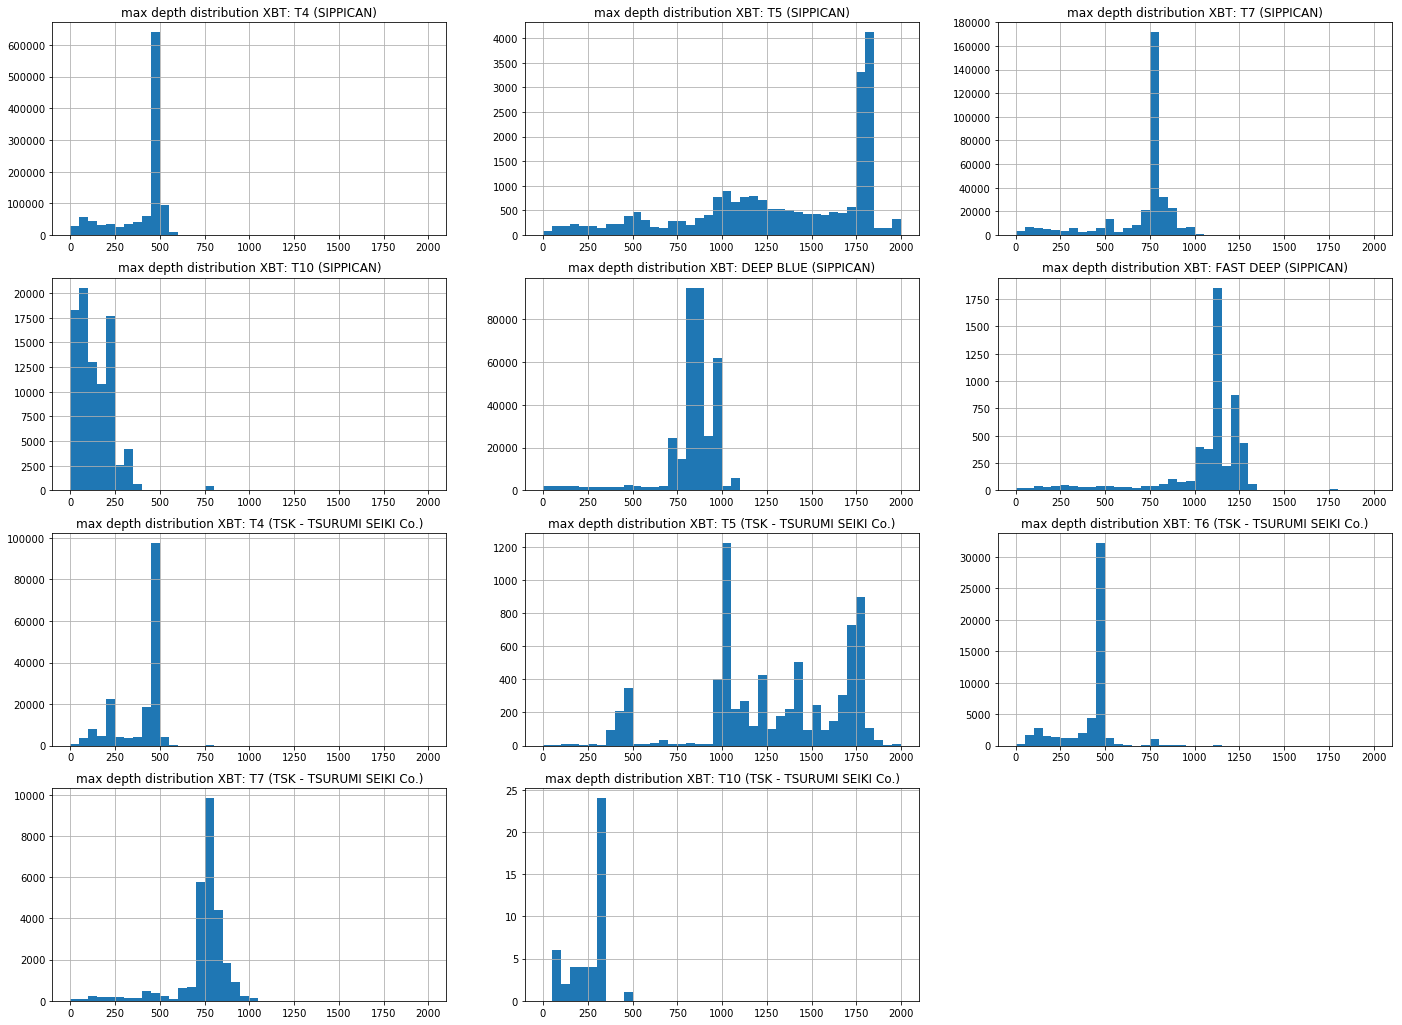

In [41]:
fig_probe_freq = matplotlib.pyplot.figure('probe frequency plot grid',figsize=(24,18))
for ix1, mfi in enumerate(instruments_to_plot):
    ax_depth_dist_type = fig_probe_freq.add_subplot(4,3,ix1+1,title=f'max depth distribution {mfi}')
    _ = xbt_full_dataset.filter_obs('instrument', mfi)['max_depth'].hist(bins=depth_bins,ax=ax_depth_dist_type)


### Frequency of probe type by year
These plots show the frequency of different probe types by year of observation. This data was used to determine date thresholds in the iMeta algorithm.

In [71]:
plot_pairs = [ 
    ('XBT: T10 (SIPPICAN)', 'XBT: T4 (SIPPICAN)', lambda d1: d1<=360.0),
    ('XBT: T5 (SIPPICAN)', 'XBT: FAST DEEP (SIPPICAN)', lambda d1: d1>= 1000.0 and d1 <=1350.0),
    ('XBT: T7 (SIPPICAN)', 'XBT: DEEP BLUE (SIPPICAN)',lambda d1: d1>= 600.0 and d1 <=1000.0),
]

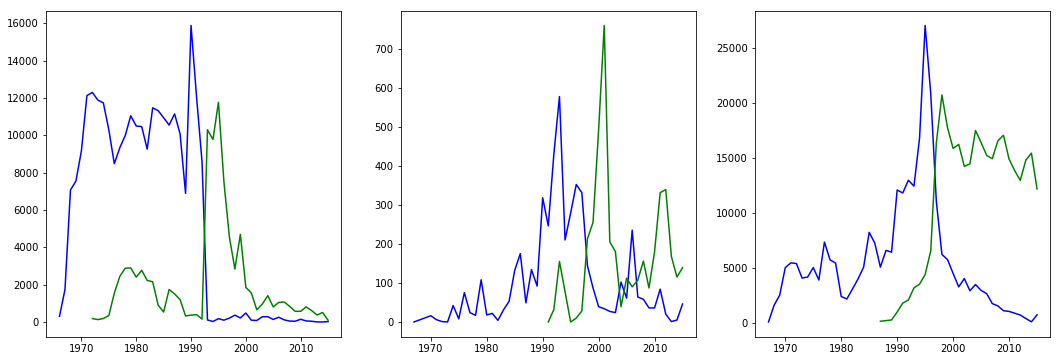

In [106]:
fig_freq_comp = matplotlib.pyplot.figure('plot types for year and max depth',figsize=(18,6))
l1 = []
for ix1, (type1, type2, filter1) in enumerate(plot_pairs):
    dataset_type1 = xbt_full_dataset.filter_obs('instrument',type1).xbt_df
    profiles_type1 = dataset_type1[dataset_type1.max_depth.apply(filter1)]
    dataset_type2 = xbt_full_dataset.filter_obs('instrument',type2).xbt_df
    profiles_type2 = dataset_type2[dataset_type2.max_depth.apply(filter1)]
    type_year_dist1 = profiles_type1.year.value_counts(sort=False)
    type_year_dist2 = profiles_type2.year.value_counts(sort=False)
    freq_df1 = pandas.DataFrame({'year': list(type_year_dist1.index), 'num_profiles': list(type_year_dist1.values)}).sort_values('year')
    freq_df2 = pandas.DataFrame({'year': list(type_year_dist2.index), 'num_profiles': list(type_year_dist2.values)}).sort_values('year')
    l1 += [(freq_df1, freq_df2)]
    ax1 = fig_freq_comp.add_subplot(130 + ix1 + 1)
    ax1.plot(list(freq_df1.year), list(freq_df1.num_profiles), color='b')
    ax1.plot(list(freq_df2.year), list(freq_df2.num_profiles), color='g')
    ax1.xmin=1950
    ax1.xmax=2020


### Accuracy of iMeta algorithm
The following plots show the accuracy of the iMeta algorihtm for observations with where the probe model and manufacturer are known.

### Probe model frequencies
These plots compare the distribution of probe model types for the profiles with model data compared with the assignments by the iMeta algorithm.

In [ ]:
actual_labels = list(actual_classes.value_counts().keys())
actual_counts = actual_classes.value_counts().values
if len(actual_labels) > 10:
    actual_labels = actual_labels[:10] + ['other']
    actual_counts = list(actual_counts[:10]) + [sum(actual_counts[10:])]

In [ ]:
imeta_labels = list(imeta_classes.value_counts().keys())
imeta_counts = list(imeta_classes.value_counts().values)

In [ ]:
fig_name_probe_freqs = 'xbt probe type frequencies'
current_figure = matplotlib.pyplot.figure(fig_name_probe_freqs, figsize=(24,12))
axes_actual_types = current_figure.add_subplot(121)
actual_plot_objs = axes_actual_types.pie(actual_counts,labels=actual_labels)
axes_imeta_types = current_figure.add_subplot(122)
imeta_plot_objs = axes_imeta_types.pie(imeta_counts,labels=imeta_labels)
current_figure.savefig(fig_name_probe_freqs + '.png')